#### Purpose of the notebook
The code retrieves GDP forecasts from the European Central Bank (ECB).

1. **Initialize Data**: Set up lists of time periods and countries.
2. **Generate Combinations**: Create combinations of periods and countries for data retrieval.
3. **ECB Data Request Setup**: Prepare for data requests from the ECB.
4. **Data Retrieval Loop**: Iterate through each combination, fetching and processing data:
   - Retrieve data for each period-country pair.
   - Process and format the retrieved data.
   - Consolidate the data into a comprehensive DataFrame.
5. **Finalize Data**: Perform any final data manipulations (currently placeholder).
6. **Display Results**: Present the compiled data in a Data  Frme format.


Source: https://data.ecb.europa.eu/data/datasets/MPD/structure

| Item | Concept Description | Concept | Code List | Values |
|------|---------------------|---------|-----------|--------|
| 1.   | Frequency            | FREQ    | CL_FREQ   | A - Annual |
| 2.   | Reference area       | REF_AREA| CL_AREA_EE| Country code|
| 3.   | Projection database item | PD_ITEM | CL_PD_ITEM | PCU - Price and cost developments |
| 4.   | Series denominat/spec calcul | SERIES_DENOM | CL_SERIES_DENOM_PD | A - Annual growth rate |
| 5.   | Projection database season exercise | PD_SEAS_EX | CL_PD_SEAS_EX | A - Autumn, G - Spring |
| 6.   | Projection database data origin | PD_ORIGIN | CL_PD_ORIGIN | 0000 - Finalised/latest data |

In [1]:
import pandasdmx as sdmx
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Create required combinations
periods = [f"A{str(i).zfill(2)}" for i in range(1, 23)]
countries = ['DE', 'FR', 'NL']
combinations = list(itertools.product(periods, countries))

# Create a request instance for the ECB
ecb = sdmx.Request('ECB')
dataflow_id = 'MPD'

# Container for results
results = pd.DataFrame()

for a, b in combinations:
    # print(a, b)
    series_key = f'A.{b}.YER.A.{a}.0000'

    # Retrieve the data
    data_response = ecb.data(dataflow_id, key=series_key)
    df = data_response.to_pandas().reset_index()

    # Splitting the 'Code' into two columns: 'Season' and 'Year'
    df['Season'] = df['PD_SEAS_EX'].str[0]
    df['Forecast_year'] = '20' + df['PD_SEAS_EX'].str[1:]
    
    # Mapping seasons to their full names
    season_map = {'A': 'Autumn', 'B': 'Winter', 'C': 'Spring', 'D': 'Summer'}
    df['Season'] = df['Season'].map(season_map)
    
    df['Forecast_year'] = df['Forecast_year'].astype(int)
    df['TIME_PERIOD'] = df['TIME_PERIOD'].astype(int)
    
    # Update 'Type' column to compare 'Year' with 'TIME_PERIOD' within the same row
    df['Type'] = df.apply(lambda row: f'Forecast_{row["TIME_PERIOD"] - row["Forecast_year"]}_Y' 
                          if row["Forecast_year"] < row['TIME_PERIOD'] else 'Actual', axis=1)
    df['Type'] = np.where(df['TIME_PERIOD'] == df['Forecast_year'], 'Estimate', df['Type'])

    results = pd.concat([results, df], axis=0)

# Append realised outcomes to forecasts
forecast_df = results.loc[results['Type'].isin(['Actual']), ['TIME_PERIOD', 'Forecast_year', 'REF_AREA', 'value']]
forecast_df['Forecast_year'] = forecast_df['Forecast_year'] - 2
forecast_df.rename(columns={'value': 'Actual'}, inplace=True)
merged_df = pd.merge(results, forecast_df, on=['Forecast_year', 'TIME_PERIOD', 'REF_AREA'], how='left')

# Show the outcomes
merged_df[merged_df['REF_AREA'] == 'DE'].head(5)

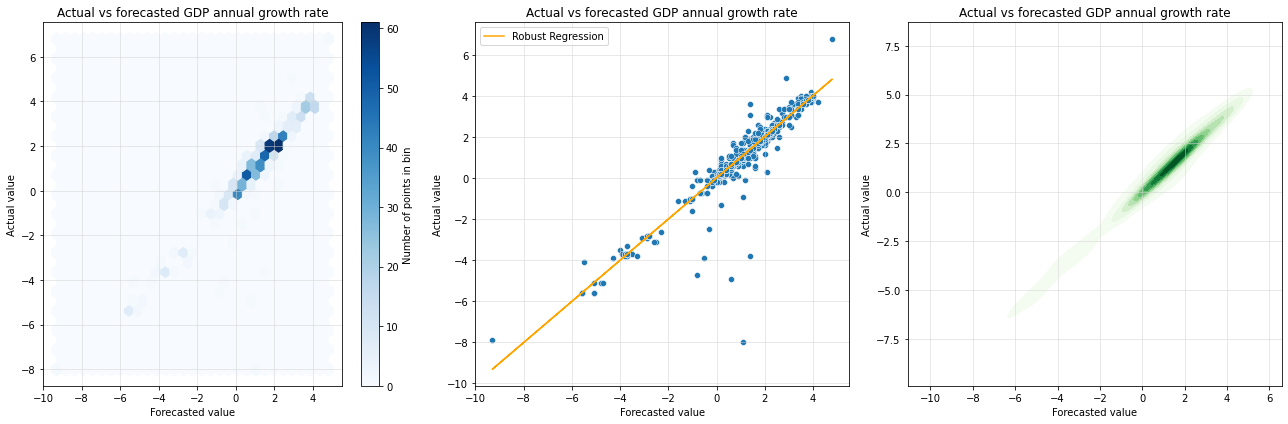

In [11]:
# Filters
idx_1 = merged_df['REF_AREA'] != 'DEN'
idx_2 = merged_df['TIME_PERIOD'] > 2000

plot_df = merged_df[idx_1 & idx_2].copy()

# Check and handle NaNs and Infs
plot_df.replace([np.inf, -np.inf], np.nan, inplace=True)
plot_df.dropna(inplace=True)

x = plot_df['value']
y = plot_df['Actual']

# Creating the plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Hexbin plot
axs[0].hexbin(x, y, gridsize=30, cmap='Blues')
axs[0].set_title('Actual vs forecasted GDP annual growth rate')
axs[0].set_xlabel('Forecasted value')
axs[0].set_ylabel('Actual value')
axs[0].grid(True, linestyle='-', linewidth=0.5, color='lightgray') 
fig.colorbar(axs[0].hexbin(x, y, gridsize=30, cmap='Blues'), ax=axs[0], label='Number of points in bin')

# Scatter plot with Seaborn
sns.scatterplot(x=x, y=y, ax=axs[1])
axs[1].set_title('Actual vs forecasted GDP annual growth rate')
axs[1].set_xlabel('Forecasted value')
axs[1].set_ylabel('Actual value')
axs[1].grid(True, linestyle='-', linewidth=0.5, color='lightgray')

# Adding a robust regression line to the scatter plot
X = sm.add_constant(x)  # Adding a constant term to the predictor
model_robust = sm.RLM(y, X).fit()
y_pred_robust = model_robust.predict(X)
axs[1].plot(x, y_pred_robust, color='orange', label='Robust regression')
axs[1].legend()

# Kernel Density Estimate (KDE) Plot
sns.kdeplot(x=x, y=y, cmap='Greens', fill=True, ax=axs[2])
axs[2].set_title('Actual vs forecasted GDP annual growth rate')
axs[2].set_xlabel('Forecasted value')
axs[2].set_ylabel('Actual value')
axs[2].grid(True, linestyle='-', linewidth=0.5, color='lightgray') 

plt.tight_layout()
plt.show()